# **Stock Price Prediction with LSTM**

### Connect to Google Drive

In [1]:
# Kết nối Google drive để lưu tài nguyên
from google.colab import drive
drive.mount('/content/drive')

# Chuyển đến thư mục
%cd /content/drive/My Drive/Individual AI Project/dv/

Mounted at /content/drive
/content/drive/My Drive/Individual AI Project/dv


In [2]:
# !pip install tensorflow==2.16.1
# !pip install keras==3.3.3
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

2.15.0
2.15.0


### Import libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Input


from sklearn.preprocessing import MinMaxScaler

from datetime import datetime
import time
from datetime import timedelta
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

from keras.models import load_model

### Read the dataset

In [4]:
symbol = 'BID'

In [5]:
df=pd.read_csv(f'csvdata/{symbol}.csv')

# Chuyển đổi cột 'Date' thành DateTime object
df['Date'] = pd.to_datetime(df['Date'])

# Đổi tên các cột
df.rename(columns={'Price': 'Close'}, inplace=True)
df.rename(columns={'Stock symbol': 'symbolid'}, inplace=True)

# Loại bỏ các hàng mà giá 'Close' là NaN.
df = df.dropna(subset=['Close'])

df.head()

,Date,Close,Open,High,Low,Vol.,Change %,symbolid,Bank
0,2014-01-27,11054.8,11235.1,11295.2,10874.6,4270000.0,-2.13,BID,BIDV
1,2014-02-06,10574.2,10934.7,10994.8,10574.2,1260000.0,-4.35,BID,BIDV
2,2014-02-07,9973.4,10454.0,10514.1,9913.3,3930000.0,-5.68,BID,BIDV
3,2014-02-10,10213.7,9913.3,10333.9,9733.1,5330000.0,2.41,BID,BIDV
4,2014-02-11,10153.6,10333.9,10333.9,10153.6,2550000.0,-0.59,BID,BIDV


### Analyze the closing prices from dataframe

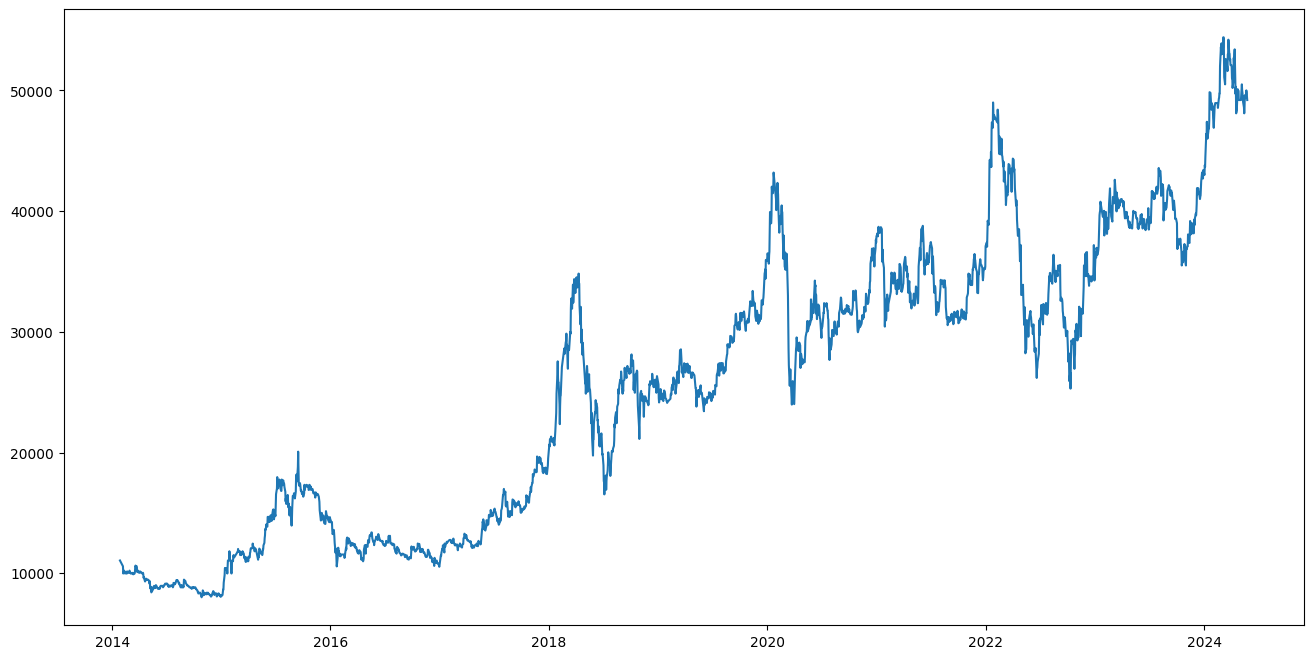

In [6]:
df["Date"]=pd.to_datetime(df.Date,format="%Y-%m-%d")
df.index=df['Date']

plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

### Sort the dataset on date time and filter “Date” and “Close” columns

In [7]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

new_dataset.tail()

,Date,Close
2567,2024-05-20 00:00:00,49600.0
2568,2024-05-21 00:00:00,50000.0
2569,2024-05-22 00:00:00,49800.0
2570,2024-05-23 00:00:00,49500.0
2571,2024-05-24 00:00:00,49200.0


### Normalize the new filtered dataset

In [8]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

train_size = int(len(final_dataset) * 0.8)
train_data = final_dataset[:train_size, :]
valid_data = final_dataset[train_size:, :]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])

x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))


### Build and train the LSTM model

In [ ]:
# Load LSTM Model (to make predictions if you have trained it)
# lstm_model = load_model("saved_model.keras")

In [9]:

# Build and train the LSTM model
lstm_model = Sequential()
lstm_model.add(Input(shape=(x_train_data.shape[1], 1)))
lstm_model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))  # Add L2 regularization
lstm_model.add(Dropout(0.3))  # Increase dropout
lstm_model.add(LSTM(units=50, kernel_regularizer=l2(0.01)))  # Add L2 regularization
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics = ["accuracy"])

# Add EarlyStopping to avoid overfitting
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

validation_split = 0.2
history = lstm_model.fit(x_train_data, y_train_data, epochs=100, batch_size=64, verbose=2, validation_split=validation_split) # callbacks=[early_stopping]

Epoch 1/100
25/25 - 9s - loss: 0.6818 - accuracy: 6.2617e-04 - val_loss: 0.5157 - val_accuracy: 0.0000e+00 - 9s/epoch - 356ms/step
Epoch 2/100
25/25 - 4s - loss: 0.4046 - accuracy: 6.2617e-04 - val_loss: 0.3059 - val_accuracy: 0.0000e+00 - 4s/epoch - 168ms/step
Epoch 3/100
25/25 - 3s - loss: 0.2350 - accuracy: 6.2617e-04 - val_loss: 0.1730 - val_accuracy: 0.0000e+00 - 3s/epoch - 120ms/step
Epoch 4/100
25/25 - 2s - loss: 0.1333 - accuracy: 6.2617e-04 - val_loss: 0.0970 - val_accuracy: 0.0000e+00 - 2s/epoch - 83ms/step
Epoch 5/100
25/25 - 2s - loss: 0.0743 - accuracy: 6.2617e-04 - val_loss: 0.0539 - val_accuracy: 0.0000e+00 - 2s/epoch - 70ms/step
Epoch 6/100
25/25 - 2s - loss: 0.0408 - accuracy: 6.2617e-04 - val_loss: 0.0347 - val_accuracy: 0.0000e+00 - 2s/epoch - 70ms/step
Epoch 7/100
25/25 - 2s - loss: 0.0234 - accuracy: 6.2617e-04 - val_loss: 0.0219 - val_accuracy: 0.0000e+00 - 2s/epoch - 71ms/step
Epoch 8/100
25/25 - 2s - loss: 0.0136 - accuracy: 6.2617e-04 - val_loss: 0.0183 - val_a

In [10]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30651 (119.73 KB)
Trainable params: 30651 (119.73 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Take a sample of a dataset to make stock price predictions using the LSTM model

In [11]:
inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)


17/17 [==============================] - 3s 45ms/step


### Save the LSTM model

In [ ]:
# lstm_model.save("saved_model.keras")

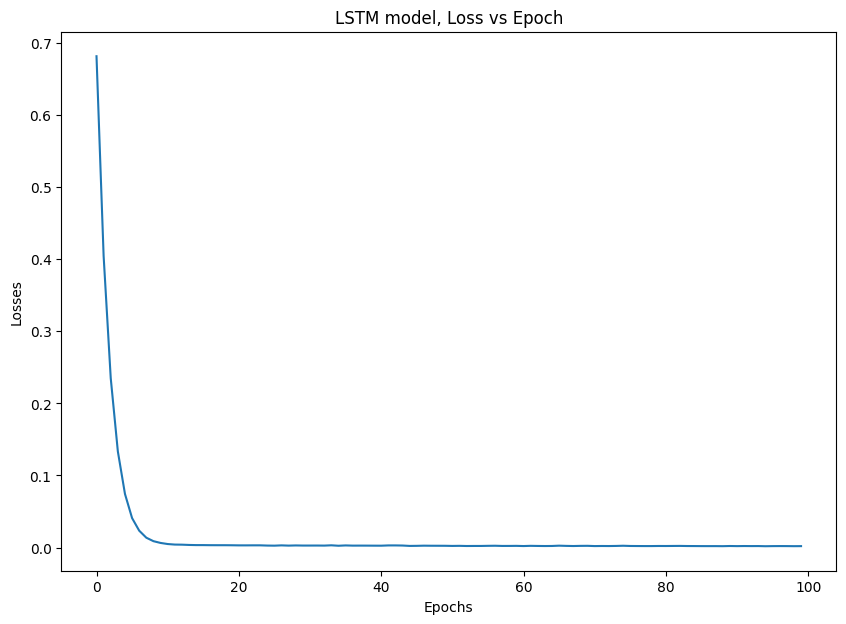

In [16]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

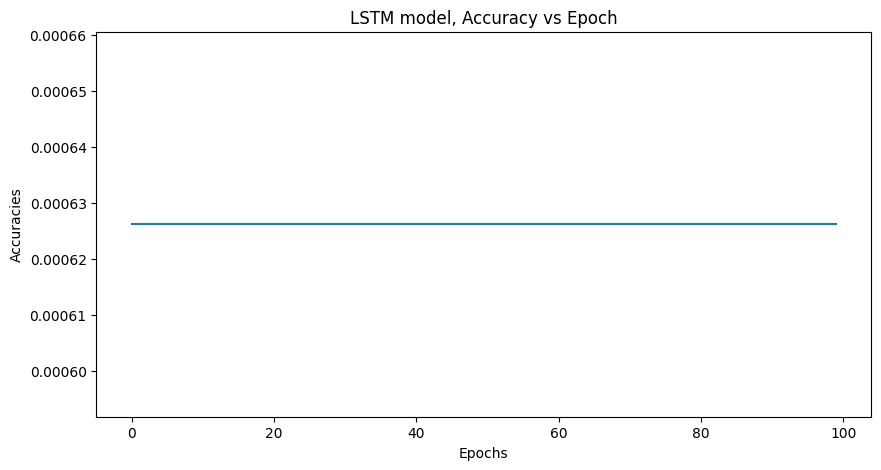

In [17]:
# Plotting Accuracy vs Epochs
plt.figure(figsize =(10,5))
plt.plot(history.history["accuracy"])
plt.xlabel("Epochs")
plt.ylabel("Accuracies")
plt.title("LSTM model, Accuracy vs Epoch")
plt.show()

### Visualize the predicted stock costs with actual stock costs

<ipython-input-14-5c9ca86cff4b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


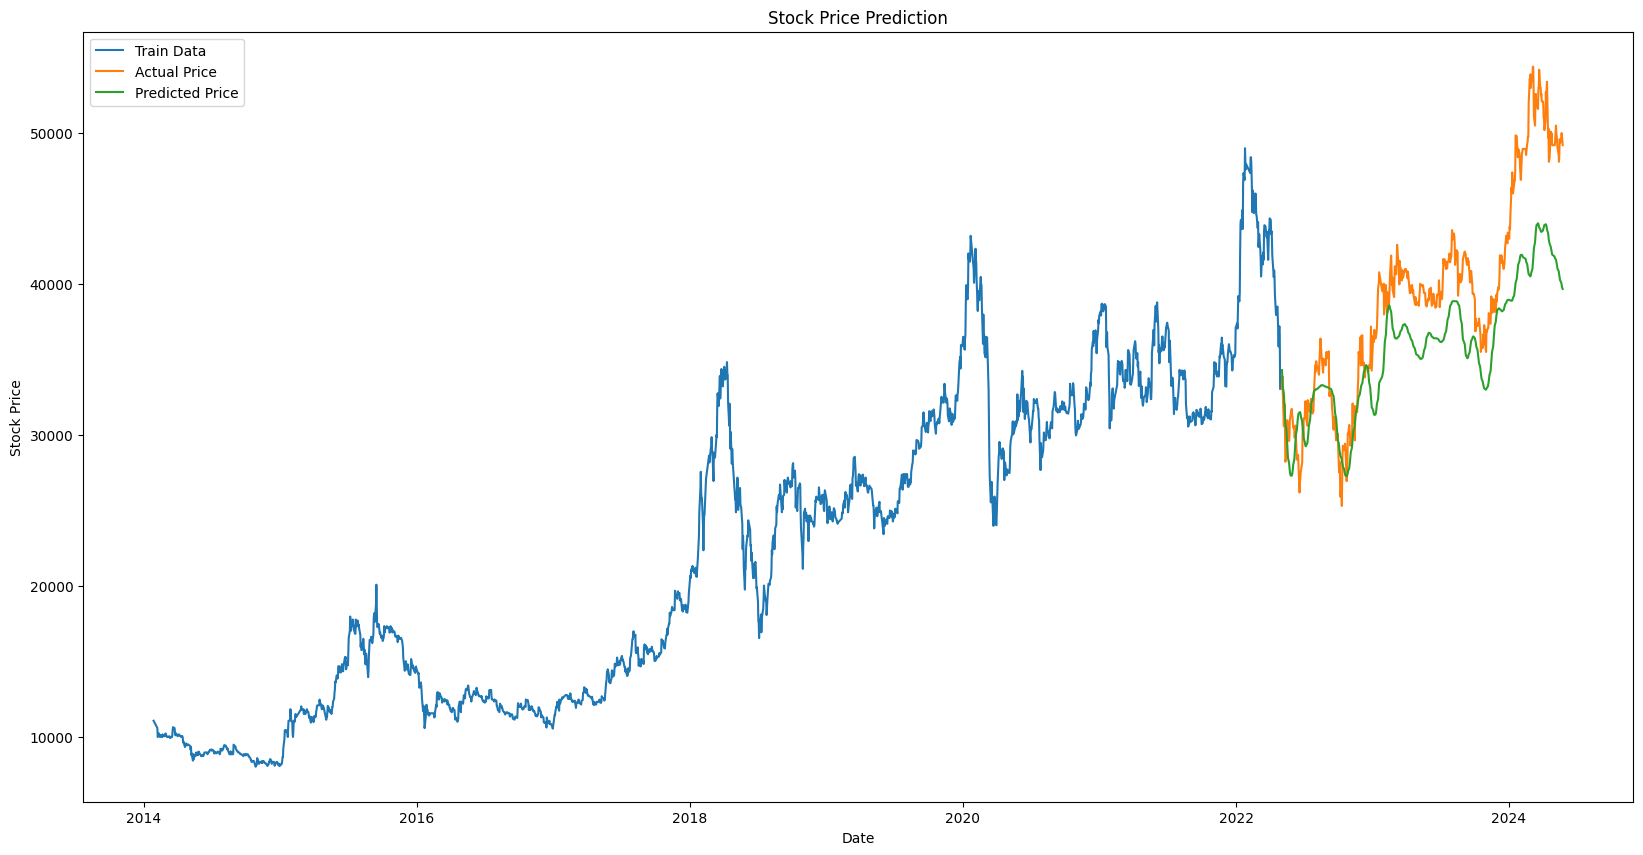

In [14]:
train_data=new_dataset[:train_size]
valid_data=new_dataset[train_size:]
valid_data['Predictions']=predicted_closing_price

plt.plot(train_data["Close"], label='Train Data')
plt.plot(valid_data["Close"], label='Actual Price')
plt.plot(valid_data["Predictions"], label='Predicted Price')

plt.legend()

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.show()

### Visualize the predicted stock costs in future

In [15]:
# Make future predictions until December 2025
future_dates = pd.date_range(start=df['Date'].max() + timedelta(days=1), end='2025-12-31', freq='B')
future_predictions = []

# Start with the last 60 days of data
last_60_days = scaled_data[-60:].reshape(1, 60, 1)

for date in future_dates:
    predicted_price = lstm_model.predict(last_60_days)
    future_predictions.append(predicted_price[0, 0])
    # Add the predicted price to the input data and maintain the shape
    predicted_price_reshaped = predicted_price.reshape(1, 1, 1)
    last_60_days = np.append(last_60_days[:, 1:, :], predicted_price_reshaped, axis=1)

# Inverse transform the predictions to get actual prices
future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = scaler.inverse_transform(future_predictions)

# Create a DataFrame for future predictions
future_df = pd.DataFrame({'Date': future_dates, 'Predictions': future_predictions.flatten()})
future_df.set_index('Date', inplace=True)

1/1 [==============================] - 0s 38ms/step


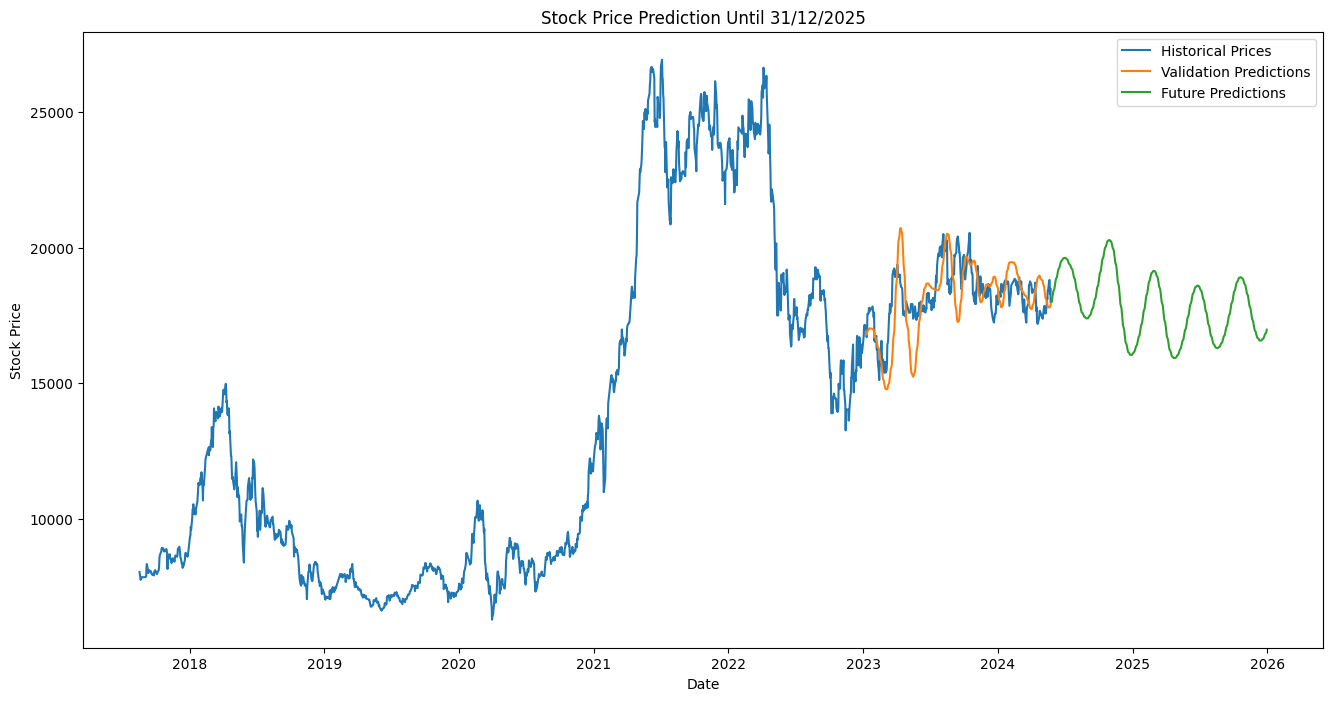

In [ ]:
# Plot the future predictions
plt.figure(figsize=(16, 8))
plt.plot(df["Close"], label='Historical Prices')
plt.plot(valid_data['Predictions'], label='Validation Predictions')
plt.plot(future_df['Predictions'], label='Future Predictions')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction Until 31/12/2025')
plt.show()

In [ ]:
# # Create a dataframe for validation predictions
# valid_dates = new_dataset.index[train_size:]
# valid_df = pd.DataFrame({'Date': valid_dates, 'Prediction': predicted_closing_price.flatten()})
# valid_df.set_index('Date', inplace=True)

# # Merge predictions with original dataframe and save to CSV
# df['Prediction'] = np.nan
# df.loc[valid_df.index, 'Prediction'] = valid_df['Prediction']

# # Create a DataFrame for future predictions with NaN for 'Close'
# future_df_full = pd.DataFrame({'Date': future_dates, 'Close': np.nan, 'Prediction': future_predictions.flatten()})
# future_df_full.set_index('Date', inplace=True)

# # Append future predictions to the original DataFrame
# combined_df = pd.concat([df, future_df_full])

# # Drop columns, only keep Date, Close and Prediction
# combined_df = combined_df[['Close', 'Prediction']]

# combined_df.tail(5)

,Close,Prediction
Date,,
2025-12-25,NaN,16759.546875
2025-12-26,NaN,16805.984375
2025-12-29,NaN,16856.902344
2025-12-30,NaN,16912.167969
2025-12-31,NaN,16971.644531


In [ ]:
# # Save to CSV
# combined_df.to_csv(f'csvdata/{symbol}_predictions.csv')

In [ ]:
# symbol_list = ['AGR', 'BID', 'CTG', 'TCB', 'VCB', 'VPB']
# # Load all csv predictions and combined to one file
# all_predictions = pd.DataFrame()

# for symbol in symbol_list:
#     predictions = pd.read_csv(f'csvdata/{symbol}_predictions.csv')
#     predictions['symbolid'] = symbol
#     predictions=predictions[['Date','symbolid','Close','Prediction']]
#     all_predictions = pd.concat([all_predictions, predictions])

# print(all_predictions.shape)
# all_predictions.sample(5)

(19287, 4)


,Date,symbolid,Close,Prediction
2926,2021-03-23,VCB,74167.0,NaN
2813,2020-10-23,CTG,23709.8,NaN
1418,2023-04-24,VPB,17647.9,18971.404297
1786,2016-08-29,VCB,30982.0,NaN
1648,2024-03-26,VPB,18610.1,17954.748047


In [ ]:
# # Save to CSV
# # Set index by Date and symbolid
# all_predictions = all_predictions.set_index(['Date', 'symbolid'])
# all_predictions.to_csv(f'csvdata/all_predictions.csv')
# all_predictions.tail(5)

,,Close,Prediction
Date,symbolid,,
2025-12-25,VPB,NaN,16759.546875
2025-12-26,VPB,NaN,16805.984375
2025-12-29,VPB,NaN,16856.902344
2025-12-30,VPB,NaN,16912.167969
2025-12-31,VPB,NaN,16971.644531
